##*SMS Spam Detection Using 7 Machine Learning Algorithms and Simple Bag of Words*

By Nakshatra Singh

###**1. Retrieve and Inspect Dataset** 

Let's download the dataset which is uploaded on my google drive. 

In [42]:
!gdown --id 1P-HE8p7bb9rS5HYvcIu2CXani_hM-IO7

Downloading...
From: https://drive.google.com/uc?id=1P-HE8p7bb9rS5HYvcIu2CXani_hM-IO7
To: /content/spam.csv
100% 504k/504k [00:00<00:00, 68.3MB/s]


We'll use `pandas` to parse the csv files. 

In [43]:
import pandas as pd
df = pd.read_csv('/content/spam.csv', encoding='latin-1')

Let's take a look at the first few rows of the table just to see what's in there. 

In [44]:
df.head() 

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


What's the shape of the dataframe?
 

In [45]:
df.shape 

(5572, 5)

Does the dataframe contain any null row values? 

In [46]:
df.isnull().sum()  

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Let's drop the Unwanted columns, and rename the columns to something we can understand.

In [47]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns = {'v1':'label','v2':'message'}) 

Let's see how the dataframe looks like.

In [48]:
df.head() 

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's drop the duplicate rows present in the dataset.

In [49]:
df.drop_duplicates(subset ="message", keep = False, inplace = True) 

Did the data points reduce?

In [50]:
df.shape

(4888, 2)

YESS!! That means we had a few duplicate data points, but now they are removed.

Let's see the length of each message.

In [51]:
df['length'] = df['message'].apply(len)
df.head() 

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148


Let's visualize it a little further using matplotlib.

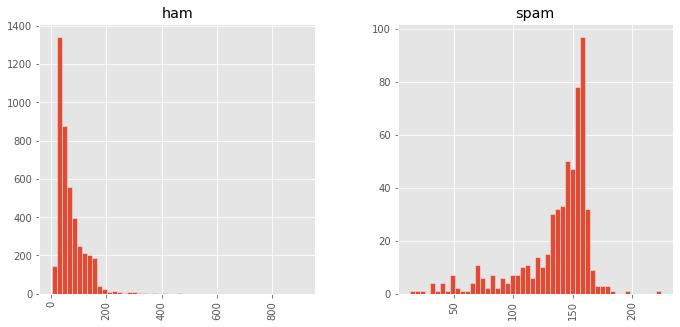

In [52]:
import matplotlib.pyplot as plt

plt.rcParams['patch.force_edgecolor'] = True
plt.style.use('ggplot')
df.hist(column='length', by='label', bins=50, figsize=(11,5));

Now, let's do some basic statistical analysis of the attributes.

In [53]:
for i in df.columns:
  print("Basic Statistics for Feature: {0}".format(i))
  print(df[i].describe())
  print("==========================================")

Basic Statistics for Feature: label
count     4888
unique       2
top        ham
freq      4322
Name: label, dtype: object
Basic Statistics for Feature: message
count                        4888
unique                       4888
top       Check with nuerologist.
freq                            1
Name: message, dtype: object
Basic Statistics for Feature: length
count    4888.000000
mean       77.338380
std        56.812841
min         3.000000
25%        36.000000
50%        59.000000
75%       112.000000
max       910.000000
Name: length, dtype: float64


##**2. NLTK**

We'll use nltk stopwords to remove words which provide us no valuable information.

In [54]:
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Next, I'll write a helper function which will preprocess our texts.

In [55]:
import string
def process_text(text):
  nopunc = [char for char in text if char not in string.punctuation]
  nopunc = ''.join(nopunc)

  clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

  return clean_words 

Let's apply this function to the complete dataset.

In [56]:
df['message'].head().apply(process_text)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
5    [FreeMsg, Hey, darling, 3, weeks, word, back, ...
Name: message, dtype: object

##**3. Bag Of Words**

Let's convert all our text in the dataframe to a bag of words matrix.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
message_bow = CountVectorizer(analyzer=process_text).fit_transform(df['message'])

Let's see how many unique tokens (without stopwords) are made by CountVectorizer.

In [58]:
message_bow.shape

(4888, 10596)

Let's split the data into training and validation sets.

In [59]:
from sklearn.model_selection import train_test_split
X_train, x_validation, Y_train, y_validation = train_test_split(message_bow,
                                                                df['label'],
                                                                test_size=0.2,
                                                                stratify=df['label'],
                                                                random_state=0) 

##**4. Machine Learning Algorithms**

Let's import all the ML algorithms we'll be using in this notebook.

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

Here is something very interesting, I'll write a utility function which will input all the algorithms with the model parameters. We'll use ShuffleSplit and GridSearchCV for finding which ML algorithm (and their respective parameters) works best for this task.

In [61]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit


def find_best_model(X, y):
    models = {
        'Logistic_Regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
            'parameters': {
                'C': [1,5,10]
               }
        },
        
        'Decision_Tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5, 10]
            }
        },
        
        'Random_Forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {
                'n_estimators': [10,15,20,50,100,200]
            }
        },
        
        'SVM': {
            'model': SVC(gamma='auto'),
            'parameters': {
                'C': [1,10,20],
                'kernel': ['rbf','linear']
            }
        },

        'Multinomial_Naive_Bayes': {
            'model': MultinomialNB(),
            'parameters': {
                'alpha': [0.5, 1, 2, 3, 5, 10]
            }
        },

        'KNN': {
            'model': KNeighborsClassifier(),
            'parameters': {
                'n_neighbors': [1, 2, 3, 4, 5, 6, 8, 10, 20]
            }
        },

        'Extra_Tree': {
            'model': ExtraTreesClassifier(),
            'parameters': {
                'n_estimators': [1, 5, 10, 20, 30, 40, 50, 60, 70, 100, 150, 200],
                'max_depth': [1, 2, 5, 6, 7, 8, 10, 20, 30],
                'criterion': ['gini', 'entropy']
            }
        }

    }

    scores = [] 
    cv_shuffle = ShuffleSplit(n_splits=7, test_size=0.20, random_state=0)
        
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })
        
    return pd.DataFrame(scores, columns=['model','best_parameters','score'])

find_best_model(X_train, Y_train)

,model,best_parameters,score
0,Logistic_Regression,{'C': 10},0.972963
1,Decision_Tree,"{'criterion': 'gini', 'max_depth': 10}",0.948484
2,Random_Forest,{'n_estimators': 200},0.965108
3,SVM,"{'C': 1, 'kernel': 'linear'}",0.975703
4,Multinomial_Naive_Bayes,{'alpha': 3},0.972598
5,KNN,{'n_neighbors': 1},0.933687
6,Extra_Tree,"{'criterion': 'gini', 'max_depth': 30, 'n_esti...",0.936609


The results are quite interesting, I thought the Multinomial Naive Bayes Algorithm will be the best for this task, but Support Vector Machine is the best as it has the highest score. So we'll create 2 final classifiers and evaluate each classifiers metrics. 

##**5. Support Vector Machine**

In [62]:
# Creating Support Vector Machine Model
classifier = SVC(C=1.0, kernel='linear')
classifier.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

##**6. Model Metrics (SVM)**
Now since our model is trained, let's print out the model metrics which will define how good our model is actually doing.

In [63]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

# On training data
y_pred = classifier.predict(X_train)
print(classification_report(Y_train, y_pred))
print()
print("Confusion Matrix: \n", confusion_matrix(Y_train, y_pred))
print()
print("Accuracy: ", accuracy_score(Y_train, y_pred))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3457
        spam       1.00      1.00      1.00       453

    accuracy                           1.00      3910
   macro avg       1.00      1.00      1.00      3910
weighted avg       1.00      1.00      1.00      3910


Confusion Matrix: 
 [[3457    0]
 [   0  453]]

Accuracy:  1.0


In [64]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# On validation data
y_pred = classifier.predict(x_validation)
print(classification_report(y_validation, y_pred))
print()
print("Confusion Matrix: \n", confusion_matrix(y_validation, y_pred))
print()
print("Accuracy: ", accuracy_score(y_validation, y_pred)) 

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       865
        spam       0.99      0.83      0.90       113

    accuracy                           0.98       978
   macro avg       0.98      0.92      0.95       978
weighted avg       0.98      0.98      0.98       978


Confusion Matrix: 
 [[864   1]
 [ 19  94]]

Accuracy:  0.9795501022494888


##**7. Multinomial Naive Bayes**

In [ ]:
# Creating Multinomial Naive Bayes Model
classifier2 = MultinomialNB(alpha=3.0)
classifier2.fit(X_train, Y_train)

MultinomialNB(alpha=3.0, class_prior=None, fit_prior=True)

##**8. Model Metrics (Multinomial NB)**

In [ ]:
# On training data
y_pred = classifier2.predict(X_train)
print(classification_report(Y_train, y_pred))
print()
print("Confusion Matrix: \n", confusion_matrix(Y_train, y_pred))
print()
print("Accuracy: ", accuracy_score(Y_train, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      3457
        spam       0.99      0.91      0.95       453

    accuracy                           0.99      3910
   macro avg       0.99      0.96      0.97      3910
weighted avg       0.99      0.99      0.99      3910


Confusion Matrix: 
 [[3453    4]
 [  39  414]]

Accuracy:  0.9890025575447571


In [ ]:
# On validation data
y_pred = classifier2.predict(x_validation)
print(classification_report(y_validation, y_pred))
print()
print("Confusion Matrix: \n", confusion_matrix(y_validation, y_pred))
print()
print("Accuracy: ", accuracy_score(y_validation, y_pred)) 

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       865
        spam       0.87      0.88      0.88       113

    accuracy                           0.97       978
   macro avg       0.93      0.93      0.93       978
weighted avg       0.97      0.97      0.97       978


Confusion Matrix: 
 [[850  15]
 [ 13 100]]

Accuracy:  0.9713701431492843


It is clear that SVM performs best for this task, so we'll load it into a pickle file and download it for deployment.

##**9. Saving Model**

We'll save the model using a pickel and load it in our local system.

In [65]:
import pickle

# Creating a pickle file for the classifier
filename = 'spam-detection-svm.pkl'
pickle.dump(classifier, open(filename, 'wb')) 

##**10. Summary and Conclusion**

- We used Bag of Words to form a word token matrix.
- We used 7 different Machine Learning Algorithms.
- Implemented GridSearchCV and ShuffleSplit to find best fitting parameters.
- We also evaluated model metrics to check performance
- SVM performed the best.
- Below is a clean table with scores obtained in Hyperparameter findings.

In [66]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model Used", "Accuracy"]

x.add_row(["Logistic Regression", 0.9729])
x.add_row(["Decision Tree Classifier", 0.9484])
x.add_row(["Random Forest Classifier", 0.9651])
x.add_row(["Support Vector Machine", 0.9757])
x.add_row(["Multinomial Naive Bayes", 0.9725])
x.add_row(["KnearestNeighbor", 0.9336])
x.add_row(["Extra Tree Classifier", 0.9366])

print(x)

+--------------------------+----------+
|        Model Used        | Accuracy |
+--------------------------+----------+
|   Logistic Regression    |  0.9729  |
| Decision Tree Classifier |  0.9486  |
| Random Forest Classifier |  0.9638  |
|  Support Vector Machine  |  0.9757  |
| Multinomial Naive Bayes  |  0.9725  |
|     KnearestNeighbor     |  0.9336  |
|  Extra Tree Classifier   |  0.9369  |
+--------------------------+----------+
